#### Setting up LLM 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm =  ChatGroq(model="llama-3.3-70b-versatile")

#### Defining State Schema using Pydantic

In [2]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [3]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

In [4]:
from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

#### Node functions

In [5]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    print("Report Sections:",report_sections)
    return {"sections": report_sections.sections}

In [6]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [7]:
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [8]:
def synthesizer(state: State):
    """Synthesize full report from sections"""
    # List of completed sections
    completed_sections = state["completed_sections"]
    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

#### Creating State Graph

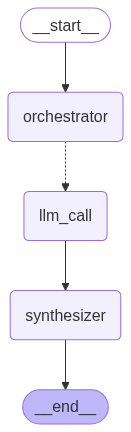

In [10]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [11]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Artificial Intelligence in Space Exploration."})
from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction to AI in Space Exploration', description='Overview of the current state of AI in space exploration, its applications, and benefits'), Section(name='History of AI in Space Exploration', description='Historical development of AI in space exploration, key milestones, and notable achievements'), Section(name='AI-Powered Spacecraft Systems', description='In-depth analysis of AI-powered systems used in spacecraft, including navigation, communication, and control systems'), Section(name='Robotic Space Exploration', description='Examination of AI-controlled robots used in space exploration, including their design, capabilities, and accomplishments'), Section(name='AI-Driven Data Analysis in Space Exploration', description='Discussion of AI-driven data analysis techniques used in space exploration, including data mining, pattern recognition, and predictive analytics'), Section(name='Challenges and Limitations of AI in Space Exploration', des

### Introduction to AI in Space Exploration
#### Overview of Current State
The current state of Artificial Intelligence (AI) in space exploration is rapidly evolving, with significant advancements in recent years. AI technologies such as machine learning, deep learning, and natural language processing are being increasingly applied in various aspects of space exploration, including spacecraft operations, data analysis, and robotic missions.

#### Applications of AI in Space Exploration
AI has numerous applications in space exploration, including:
* **Spacecraft Navigation and Control**: AI algorithms can optimize spacecraft trajectories, predict and prevent collisions, and improve navigation systems.
* **Data Analysis**: AI can process and analyze large amounts of data from space missions, including images, sensor readings, and telemetry data, to extract valuable insights and patterns.
* **Robotic Missions**: AI can control and coordinate robotic missions, such as planetary rovers and robotic arms, to perform tasks autonomously.
* **Predictive Maintenance**: AI can predict equipment failures and schedule maintenance, reducing downtime and improving overall system reliability.

#### Benefits of AI in Space Exploration
The benefits of AI in space exploration are numerous, including:
* **Improved Efficiency**: AI can automate routine tasks, freeing up human resources for more complex and creative tasks.
* **Enhanced Safety**: AI can predict and prevent accidents, improving the safety of astronauts and spacecraft.
* **Increased Accuracy**: AI can analyze large amounts of data, reducing errors and improving the accuracy of space missions.
* **Cost Savings**: AI can optimize resource allocation, reduce energy consumption, and improve overall system performance, resulting in significant cost savings.

---

### History of AI in Space Exploration
#### Introduction to AI in Space
The integration of Artificial Intelligence (AI) in space exploration has a history that spans several decades. The first notable use of AI in space exploration was in the 1960s, with the development of the Block II computers used in the Apollo missions. These computers utilized a form of AI to control the spacecraft's systems and navigate through space.

#### Key Milestones
* **1970s:** The first autonomous spacecraft, Voyager 1 and 2, were launched, utilizing AI to navigate and communicate with Earth.
* **1980s:** The introduction of expert systems, a type of AI, in spacecraft such as the Space Shuttle, enabled more efficient and automated decision-making.
* **1990s:** The Mars Pathfinder mission demonstrated the use of AI in planetary exploration, with the Sojourner rover using AI to navigate and analyze data.
* **2000s:** The launch of the Mars Exploration Rovers, Spirit and Opportunity, further showcased the capabilities of AI in space exploration, with the rovers using AI to navigate and analyze data.

#### Notable Achievements
* **Autonomous Navigation:** The use of AI in autonomous navigation has enabled spacecraft to navigate through space and planetary bodies with increased accuracy and efficiency.
* **Data Analysis:** AI has been used to analyze vast amounts of data collected by spacecraft, enabling scientists to gain a deeper understanding of the universe and make new discoveries.
* **Robotics:** The use of AI in robotics has enabled the development of more advanced and autonomous robots, such as the Mars Curiosity Rover, which has been used to explore planetary surfaces.
* **Deep Space Exploration:** AI has played a crucial role in deep space exploration, enabling spacecraft to travel further and longer than ever before, and to communicate with Earth more efficiently.

---

### AI-Powered Spacecraft Systems
#### Introduction to AI in Spacecraft
AI-powered systems are increasingly being used in spacecraft to improve navigation, communication, and control. These systems utilize machine learning algorithms and artificial intelligence to process vast amounts of data, make decisions, and perform tasks autonomously.

#### Navigation Systems
* **Autonomous Navigation**: AI-powered navigation systems enable spacecraft to navigate through space without human intervention. These systems use a combination of sensors, GPS, and machine learning algorithms to determine the spacecraft's position, velocity, and trajectory.
* **Route Optimization**: AI can optimize routes for spacecraft, taking into account factors such as fuel consumption, time, and astronomical events. This enables spacecraft to travel more efficiently and reduce the risk of collisions.

#### Communication Systems
* **Data Transmission**: AI-powered communication systems can optimize data transmission between spacecraft and ground stations. These systems use machine learning algorithms to predict and adapt to changing communication conditions, ensuring reliable and efficient data transfer.
* **Signal Processing**: AI can be used to process and analyze signals received from spacecraft, enabling scientists to extract valuable insights and information from the data.

#### Control Systems
* **Attitude Control**: AI-powered control systems can maintain a spacecraft's attitude and stability, ensuring the spacecraft remains pointing in the correct direction and maintaining communication with ground stations.
* **Fault Detection**: AI can detect faults and anomalies in spacecraft systems, enabling prompt corrective action to be taken and reducing the risk of system failures.

#### Benefits and Challenges
* **Benefits**: AI-powered spacecraft systems offer numerous benefits, including improved efficiency, increased autonomy, and enhanced decision-making capabilities.
* **Challenges**: However, the development and deployment of AI-powered spacecraft systems also pose significant challenges, including the need for advanced computing capabilities, reliable data storage, and robust security measures to prevent cyber threats.

#### Future Developments
* **Edge Computing**: The integration of edge computing in spacecraft systems will enable real-time processing and analysis of data, reducing latency and improving decision-making capabilities.
* **Swarm Intelligence**: The development of swarm intelligence in spacecraft systems will enable multiple spacecraft to work together, sharing resources and coordinating actions to achieve complex tasks and missions.

---

### Robotic Space Exploration
#### Introduction to Robotic Space Exploration
Robotic space exploration involves the use of AI-controlled robots to explore and gather data from space. These robots are designed to withstand the harsh conditions of space and can operate autonomously, making them ideal for long-duration missions.

#### Design and Capabilities
The design of robotic space explorers varies depending on their intended mission and destination. Some common features include:
* **Solar panels** or **nuclear reactors** to provide power
* **Communication systems** to transmit data back to Earth
* **Propulsion systems** such as rockets or ion thrusters to maneuver
* **Sensors and cameras** to gather data and images
* **Robotic arms** or **sample collection systems** to interact with the environment

Robotic space explorers have a range of capabilities, including:
* **Autonomous navigation** and decision-making
* **Real-time data analysis** and transmission
* **Sample collection and analysis**
* **Long-duration operation** in extreme environments

#### Accomplishments
Robotic space explorers have achieved numerous significant accomplishments, including:
* **Landing on Mars** and exploring the Martian surface
* **Exploring the outer planets** and their moons
* **Conducting asteroid and comet flybys**
* **Gathering data on the Earth's climate** and natural resources
* **Testing technologies** for future human missions to space

Examples of successful robotic space explorers include:
* **NASA's Curiosity Rover**, which has been operating on Mars since 2012
* **ESA's Rosetta Mission**, which successfully landed a probe on a comet in 2014
* **NASA's Cassini Mission**, which explored Saturn and its moons from 2004 to 2017

#### Future Directions
The future of robotic space exploration is likely to involve even more advanced technologies, such as:
* **Artificial intelligence** and **machine learning** to enable more autonomous decision-making
* **Swarm robotics** to coordinate multiple robots for complex missions
* **In-orbit assembly** and **manufacturing** to enable the construction of larger spacecraft
* **Human-robot collaboration** to support future human missions to space

---

### AI-Driven Data Analysis in Space Exploration
#### Introduction to AI-Driven Data Analysis
AI-driven data analysis techniques have revolutionized the field of space exploration, enabling scientists to extract valuable insights from vast amounts of data collected by spacecraft and satellites. Data mining, pattern recognition, and predictive analytics are some of the key techniques used in this context.

#### Data Mining in Space Exploration
Data mining involves the use of automated methods to identify patterns and relationships in large datasets. In space exploration, data mining is used to analyze data from various sources, such as:
* **Spacecraft telemetry**: Data mining is used to identify patterns in spacecraft performance, detect anomalies, and predict potential failures.
* **Astronomical observations**: Data mining is used to identify patterns in astronomical data, such as the detection of exoplanets, asteroids, and comets.
* **Planetary data**: Data mining is used to analyze data from planetary missions, such as the detection of water on Mars, and the study of planetary atmospheres.

#### Pattern Recognition in Space Exploration
Pattern recognition involves the use of machine learning algorithms to identify patterns in data. In space exploration, pattern recognition is used to:
* **Detect celestial objects**: Pattern recognition is used to detect celestial objects, such as stars, galaxies, and black holes.
* **Analyze spacecraft images**: Pattern recognition is used to analyze images from spacecraft, such as the detection of craters, mountains, and other geological features.
* **Predict spacecraft trajectories**: Pattern recognition is used to predict spacecraft trajectories, and detect potential collisions.

#### Predictive Analytics in Space Exploration
Predictive analytics involves the use of statistical models and machine learning algorithms to predict future events. In space exploration, predictive analytics is used to:
* **Predict spacecraft performance**: Predictive analytics is used to predict spacecraft performance, and detect potential failures.
* **Forecast celestial events**: Predictive analytics is used to forecast celestial events, such as solar flares, and planetary alignments.
* **Optimize mission planning**: Predictive analytics is used to optimize mission planning, and predict the outcome of different mission scenarios.

#### Benefits and Challenges of AI-Driven Data Analysis
The use of AI-driven data analysis techniques in space exploration has several benefits, including:
* **Improved accuracy**: AI-driven data analysis techniques can improve the accuracy of data analysis, and reduce the risk of human error.
* **Increased efficiency**: AI-driven data analysis techniques can automate many tasks, and free up scientists to focus on higher-level analysis.
* **Enhanced discovery**: AI-driven data analysis techniques can enable scientists to discover new patterns and relationships in data, and make new discoveries.
However, there are also several challenges associated with the use of AI-driven data analysis techniques in space exploration, including:
* **Data quality**: The quality of the data used in AI-driven data analysis techniques can have a significant impact on the accuracy of the results.
* **Algorithmic bias**: AI-driven data analysis techniques can be biased towards certain patterns or relationships, and may not always detect the most important features in the data.
* **Interpretation of results**: The results of AI-driven data analysis techniques can be difficult to interpret, and may require significant expertise to understand.

---

### Challenges and Limitations of AI in Space Exploration
#### Technical Challenges
* **Data Transmission Delays**: Communication delays between spacecraft and Earth can hinder real-time decision-making, making it challenging to implement AI systems that rely on rapid data exchange.
* **Radiation Hardening**: Space radiation can damage AI hardware, requiring specialized components and shielding to ensure reliable operation.
* **Power and Resource Constraints**: Spacecraft have limited power and computational resources, making it essential to optimize AI algorithms for efficiency and minimize energy consumption.

#### Logistical Challenges
* **Spacecraft Design and Integration**: Incorporating AI systems into spacecraft design can be complex, requiring careful consideration of factors like thermal management, vibration, and reliability.
* **Testing and Validation**: Validating AI performance in space environments is difficult due to the unique conditions and lack of comprehensive testing facilities.
* **Maintenance and Updates**: Performing maintenance and updates on AI systems in space is a significant challenge, particularly for missions with limited or no human intervention.

#### Ethical Considerations
* **Autonomy and Decision-Making**: As AI systems become more autonomous, there are concerns about their ability to make decisions that align with human values and ethics.
* **Accountability and Liability**: The use of AI in space exploration raises questions about accountability and liability in the event of accidents or errors.
* **Transparency and Explainability**: Ensuring transparency and explainability of AI decision-making processes is crucial for building trust and understanding in AI-driven space exploration missions.

---

### Future of AI in Space Exploration
#### Introduction to AI-Driven Space Exploration
The integration of Artificial Intelligence (AI) in space exploration is poised to revolutionize the field, enabling more efficient, safer, and deeper space missions. Future applications of AI will span across various aspects of space travel and discovery, from autonomous spacecraft operations to intelligent data analysis.

#### Autonomous Spacecraft and Robotics
Autonomous spacecraft and robots, powered by AI, will play a crucial role in future space missions. These systems will be capable of making decisions in real-time, adapting to unforeseen circumstances, and navigating through uncharted territories without human intervention. This autonomy will be crucial for missions to distant planets and moons, where communication delays make real-time human control impractical.

#### Intelligent Data Analysis and Interpretation
The vast amounts of data collected during space missions pose a significant challenge for human analysts. AI algorithms, however, can process and interpret this data much faster and more accurately, uncovering patterns and insights that might elude human observers. This capability will be instrumental in discovering new celestial bodies, understanding cosmic phenomena, and unraveling the mysteries of the universe.

#### Potential Breakthroughs and Innovations
Several potential breakthroughs and innovations are on the horizon, including:
- **AI-Driven Propulsion Systems**: AI could optimize propulsion systems for greater efficiency, potentially leading to faster travel times and more accessible deep space missions.
- **In-Orbit Manufacturing and Recycling**: AI-controlled systems could manufacture new spacecraft components or recycle existing materials in orbit, significantly extending the lifespan of space missions.
- **Swarm Intelligence for Space Exploration**: Swarms of small, AI-controlled spacecraft could explore vast areas of space more efficiently than traditional single-spacecraft missions, providing unprecedented insights into the cosmos.

#### Challenges and Considerations
Despite the promising future of AI in space exploration, several challenges and considerations must be addressed, including:
- **Reliability and Security**: AI systems must be designed with redundancy and security in mind to prevent failures or hijacking that could jeopardize missions.
- **Ethical Implications**: As AI becomes more autonomous, ethical questions regarding decision-making authority, accountability, and the potential for AI to make discoveries that challenge human understanding must be considered.
- **International Cooperation and Regulation**: The global community will need to establish clear guidelines and regulations for the development and use of AI in space exploration to ensure safety, fairness, and peaceful use.

#### Conclusion
The future of AI in space exploration holds immense promise, with potential advancements that could transform our understanding of the universe and our place within it. As we embark on this journey, it is crucial to address the challenges and considerations that come with integrating AI into space missions, ensuring that these technologies serve humanity's quest for knowledge and advancement in a responsible and beneficial manner.